In [43]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Lambda, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import shap
from windowshap import StationaryWindowSHAP

# Set seeds for reproducibility
np.random.seed(7) # For NumPy
tf.random.set_seed(7) # For TensorFlow

In [44]:
## Step 0 : Setting (hyper)parameters and other variables

# Selecting the tickers and features to be used in the analysis
tickers_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
included_features = ['Open', 'Close', 'High', 'Low', 'Volume']

# Start and end dates, as well as window size as in (Chaudhary and Rajneesh, 2025)
sample_start_date = '2024-04-01'
sample_end_date = '2025-05-01'
window_size = 60


In [45]:
## Step 1 : Fetch and scale stock data using Yahoo Finance

# Download and store stock data (daily)
def get_stock_data(ticker):
    df = yf.download(ticker, start=sample_start_date, end=sample_end_date, group_by='column')
    return df[included_features]

print("Downloading and storing data...")
data_map = {ticker: get_stock_data(ticker) for ticker in tickers_list}

for ticker in tickers_list:
    df = data_map[ticker]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    data_map[ticker] = df


# Normalize each ticker separately
print("Normalizing data...")

scalers = {}
scaled_data_map = {}

for ticker in tickers_list:
    df = data_map[ticker]
    scaler = RobustScaler() # Using RobustScaler due to Volatility scale
    scaled_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)
    scaled_data_map[ticker] = scaled_df
    scalers[ticker] = scaler

print("Data prep complete.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Normalizing data...
Data prep complete.


In [ ]:
price_features = ['Open', 'Close', 'High', 'Low']
volume_feature = 'Volume'

for ticker in tickers_list:
    df = data_map[ticker]  # Your DataFrame for this ticker

    # --- Price Plot ---
    plt.figure(figsize=(14, 5))
    for feat in price_features:
        plt.plot(df.index, df[feat], label=feat)

    plt.title(f"{ticker} - Price Features (Open, Close, High, Low)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Volume Plot ---
    plt.figure(figsize=(14, 3))
    plt.plot(df.index, df[volume_feature], color='purple')
    plt.title(f"{ticker} - Volume")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
## Step 2 : Build and train LSTM models

# Build LSTM model

def build_model(n_input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=n_input_shape))
    model.add(Dropout(0.2)) 
    model.add(LSTM(32)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')

    return model

# Build sequences
def build_sequences(df, window_size):
    X, y = [], []
    arr = df.values

    close_idx = df.columns.get_loc('Close')  

    for i in range(len(df) - window_size):
        X.append(arr[i:i + window_size])
        y.append(arr[i + window_size, close_idx])

    return np.array(X), np.array(y)

# Store models and SHAP values
models = {}
X_train_sets = {}
X_test_sets = {}
y_pred_sets = {}
y_test_sets = {}
eval_metrics = {}

for ticker in tickers_list:
    print(f'\nProcessing {ticker} :')

    df = scaled_data_map[ticker]
    
    split_idx = int(len(df) * 0.8) # 80/20 train/test split
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx - window_size:] # Including overlap for sequence creatinon (double check!)
    
    X_train, y_train = build_sequences(train_df, window_size)
    X_test, y_test = build_sequences(test_df, window_size)

    X_train_sets[ticker] = X_train
    X_test_sets[ticker] = X_test
    
    # Training model
    print('Building and training...')
    model = build_model(n_input_shape=(window_size, X_train.shape[2]))
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)
    models[ticker] = model
    
    # Generate and store predictions
    print('Generating predictions...')
    y_pred = model.predict(X_test, verbose=0)
    scaler = scalers[ticker]
    close_idx = data_map[ticker].columns.get_loc('Close')

    dummy_pred = np.zeros((y_pred.shape[0], len(included_features)))
    dummy_pred[:, close_idx] = y_pred.flatten()
    inv_y_pred = scaler.inverse_transform(dummy_pred)[:, close_idx]

    dummy_test = np.zeros((y_test.shape[0], len(included_features)))
    dummy_test[:, close_idx] = y_test.flatten()
    inv_y_test = scaler.inverse_transform(dummy_test)[:, close_idx]

    # Store results
    y_pred_sets[ticker] = inv_y_pred
    y_test_sets[ticker] = inv_y_test

    # Evaluation metrics
    print('Evaluating model...')
    mae = np.mean(np.abs(inv_y_pred - inv_y_test))
    mse = mean_squared_error(inv_y_test, inv_y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((inv_y_test - inv_y_pred)/ inv_y_test)) * 100
    eval_metrics[ticker] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape
    }

eval_df = pd.DataFrame.from_dict(eval_metrics, orient='index')
eval_df.index.name = 'Ticker'
eval_df = eval_df[['mae', 'mse', 'rmse', 'mape']]

print("\nEvaluation Metrics Table:\n")
print(eval_df.to_string(float_format='%.4f'))



Processing AAPL :
Building and training...
Generating predictions...
Evaluating model...

Processing GOOGL :
Building and training...
Generating predictions...
Evaluating model...

Processing MSFT :
Building and training...
Generating predictions...
Evaluating model...

Processing AMZN :
Building and training...
Generating predictions...
Evaluating model...

Evaluation Metrics Table:

           mae       mse    rmse    mape
Ticker                                  
AAPL   15.8183  346.5915 18.6170  7.3565
GOOGL  13.2749  244.0131 15.6209  8.3360
MSFT   44.4496 2317.0233 48.1355 11.6507
AMZN   17.4070  433.4496 20.8195  9.0488


In [ ]:
## Step 3 : Compute SHAP values (GradientExplainer)

shap_values_map = {}
avg_shap_values_map = {}

def compute_shap(model, X_background, X_test):

    explainer = shap.GradientExplainer(model, X_background)
    shap_values = explainer.shap_values(X_test)
    return shap_values

for ticker in tickers_list:

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:100]  # Using first 100 samples for background, might want to be random instead
    X_test = X_test_sets[ticker]

    # Compute SHAP values
    print(f'\nComputing SHAP values for {ticker}...')
    shap_values = compute_shap(model, X_background, X_test) # Only computing for first 10 samples due to slowness of KernelExplainer
    avg_shap_values = np.mean(np.abs(shap_values), axis=0)

    shap_values_map[ticker] = shap_values
    avg_shap_values_map[ticker] = avg_shap_values

print("\nSHAP values computed.")


Computing SHAP values for AAPL...
Shape of SHAP values: (55, 60, 5, 1)
Average SHAP values shape: (60, 5, 1)

Computing SHAP values for GOOGL...
Shape of SHAP values: (55, 60, 5, 1)
Average SHAP values shape: (60, 5, 1)

Computing SHAP values for MSFT...
Shape of SHAP values: (55, 60, 5, 1)
Average SHAP values shape: (60, 5, 1)

Computing SHAP values for AMZN...
Shape of SHAP values: (55, 60, 5, 1)
Average SHAP values shape: (60, 5, 1)

SHAP values computed.


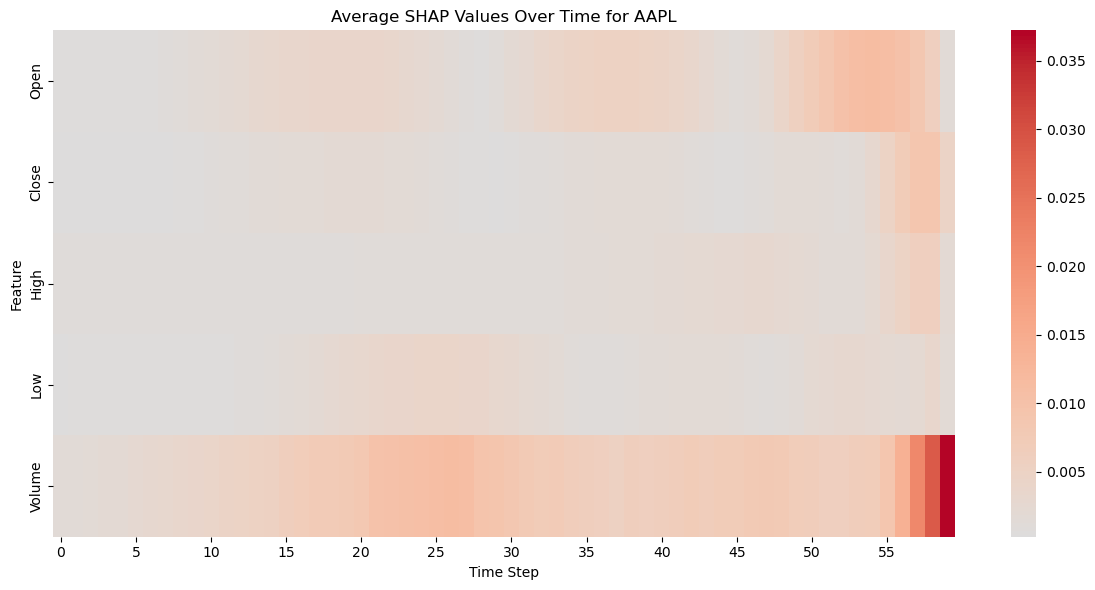

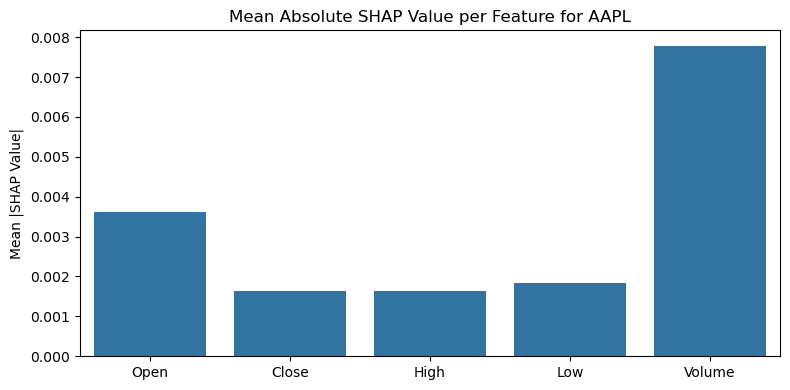

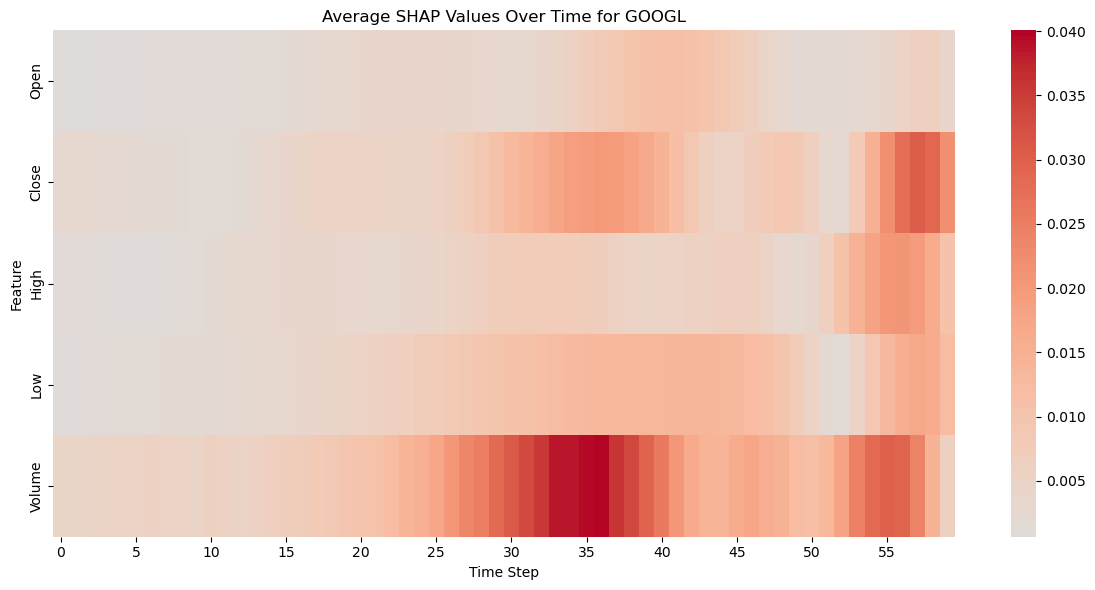

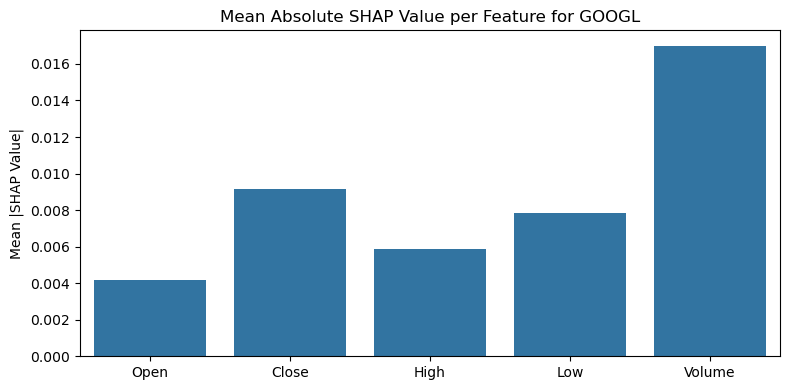

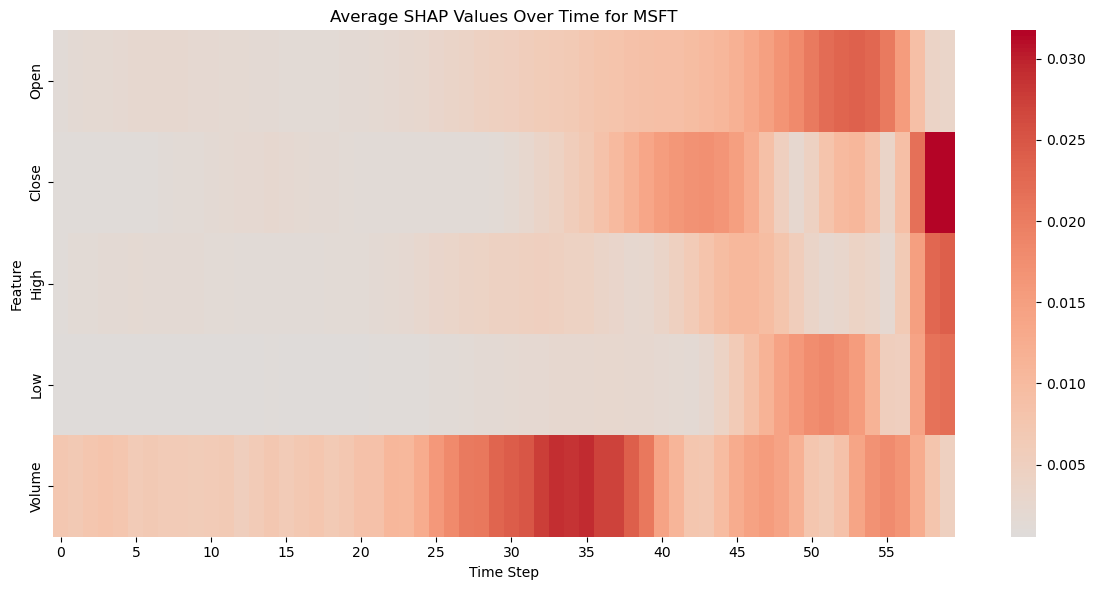

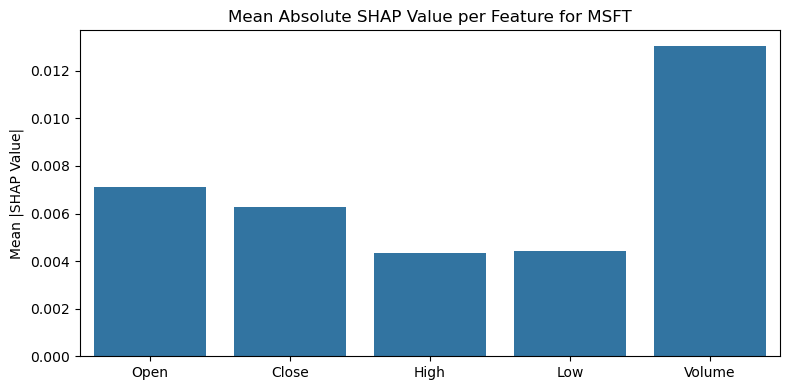

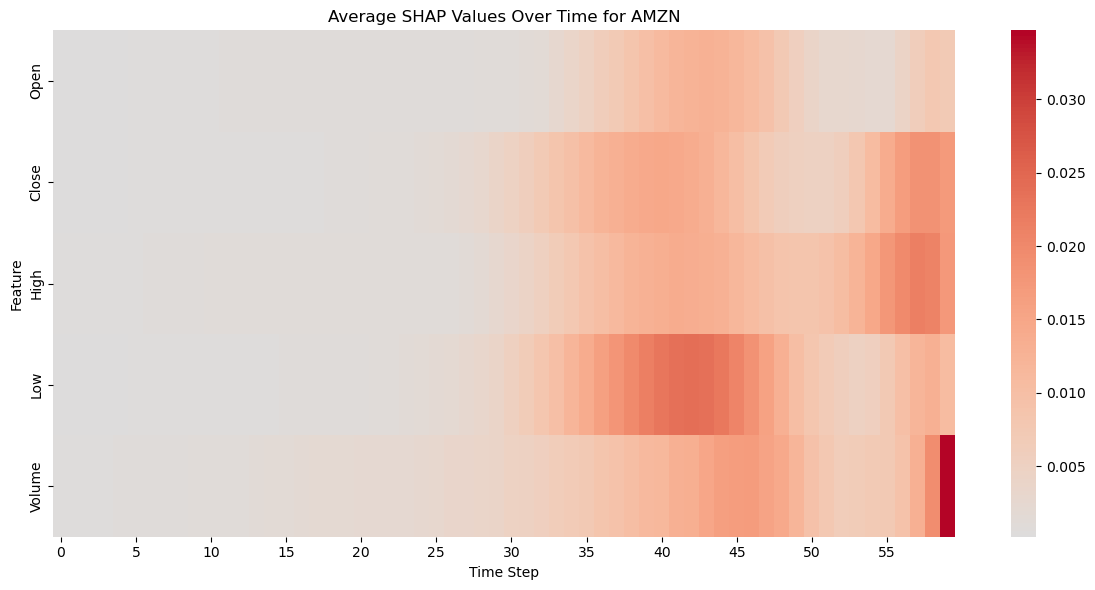

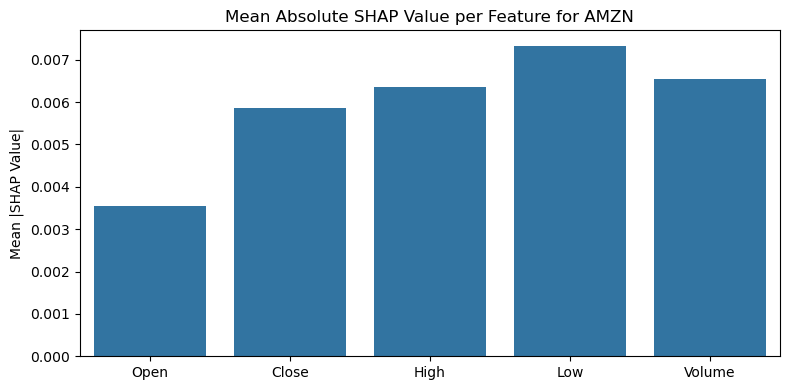

In [99]:
## Step 5 : Visualize SHAP values
shap.initjs()

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    # shap_values = shap_values_map[ticker]
    # shap_values = np.squeeze(shap_values, axis=-1)
    avg_shap_values = avg_shap_values_map[ticker]  # shape: (60, 5, 1)
    avg_shap_values = np.squeeze(avg_shap_values, axis=-1)  # shape: (60, 5)
    avg_shap_transposed = avg_shap_values.T  # shape: (5, 60)

    '''
    sample_idx = 0  # Index of the sample to visualize
    timestep = -10  # Last timestep

    shap_values_1d = shap_values[sample_idx][timestep]
    shap_values_1d = shap_values_1d.reshape(-1)
    features_1d = X_test[sample_idx][timestep]
    
    # Wrap into a SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=shap_values_1d,
        base_values=0,  # optional: set to your model's base prediction if known
        data=features_1d,
        feature_names=included_features
    )

    print(f"\nVisualizing SHAP for {ticker}...")
    shap.plots.waterfall(shap_explanation, max_display=len(included_features))
    shap.plots.force(shap_explanation, matplotlib=True)

    # --- SHAP Summary plot for all test samples ---
    print("SHAP summary plot for all test samples")
    num_samples = shap_values.shape[0]

    shap.summary_plot(
        shap_values.reshape(-1, shap_values.shape[-1]),  # shape: (samples * timesteps, features)
        X_test[:num_samples].reshape(-1, X_test.shape[-1]),  # shape: (samples * timesteps, features)
        feature_names=feature_names
    )

    # --- SHAP Heatmap over time for one prediction sequence ---
    sample_idx = 1  # You can loop or vary this to view more sequences
    print("SHAP heatmap for one prediction sequence")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        shap_values[sample_idx].T,  # shape: (features, timesteps)
        xticklabels=True,
        yticklabels=feature_names,
        cmap='coolwarm',
        center=0
    )
    plt.title(f'SHAP Values over Time for {ticker} (Sample {sample_idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    '''

    # --- Heatmap of average SHAP values over time ---
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        avg_shap_transposed,
        xticklabels=5,
        yticklabels=included_features,
        cmap='coolwarm',
        center=0,
        annot=False
    )
    plt.title(f'Average SHAP Values Over Time for {ticker}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # --- Optional: bar plot of total average impact per feature ---
    mean_importance = np.mean(np.abs(avg_shap_values), axis=0)  # shape: (5,)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=included_features, y=mean_importance)
    plt.title(f'Mean Absolute SHAP Value per Feature for {ticker}')
    plt.ylabel('Mean |SHAP Value|')
    plt.tight_layout()
    plt.show()


In [100]:
## Step 4 : Compute WindowSHAP values
window_shap_values_map = {}
avg_window_shap_values_map = {}

def compute_window_shap(model, X_background, X_test, window_size = 10):
    explainer = StationaryWindowSHAP(model, window_len=window_size, B_ts=X_background, test_ts=X_test, model_type='lstm')
    window_shap_values = explainer.shap_values()
    return window_shap_values

for ticker in tickers_list:

    print(f'Computing WindowSHAP values for {ticker}...')

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_background = X_train[:10]  # Using first 10 samples for background, might want to be random instead and 100 instead
    X_test = X_test_sets[ticker]

    ticker_windowSHAP_values = np.zeros((len(X_test), X_test.shape[1], X_test.shape[2]))

    for i in tqdm(range(len(X_test)), desc=f'Observation {i} of {len(X_test)}'):
        window_shap_values = compute_window_shap(model, X_background, X_test[i:i+1])
        ticker_windowSHAP_values[i,:,:] = window_shap_values

    avg_window_shap = np.mean(np.abs(ticker_windowSHAP_values), axis=0)  # shape: (window_size, features)

    window_shap_values_map[ticker] = ticker_windowSHAP_values
    avg_window_shap_values_map[ticker] = avg_window_shap

print("\nWindowSHAP values computed.")

Computing WindowSHAP values for AAPL...


Observation 54 of 55: 100%|██████████| 55/55 [10:56<00:00, 11.94s/it]


Computing WindowSHAP values for GOOGL...


Observation 54 of 55: 100%|██████████| 55/55 [24:52<00:00, 27.13s/it]


Computing WindowSHAP values for MSFT...


Observation 54 of 55: 100%|██████████| 55/55 [1:53:18<00:00, 123.61s/it]


Computing WindowSHAP values for AMZN...


Observation 54 of 55: 100%|██████████| 55/55 [1:05:38<00:00, 71.60s/it]


WindowSHAP values computed.


WindowSHAP heatmap of average values over time


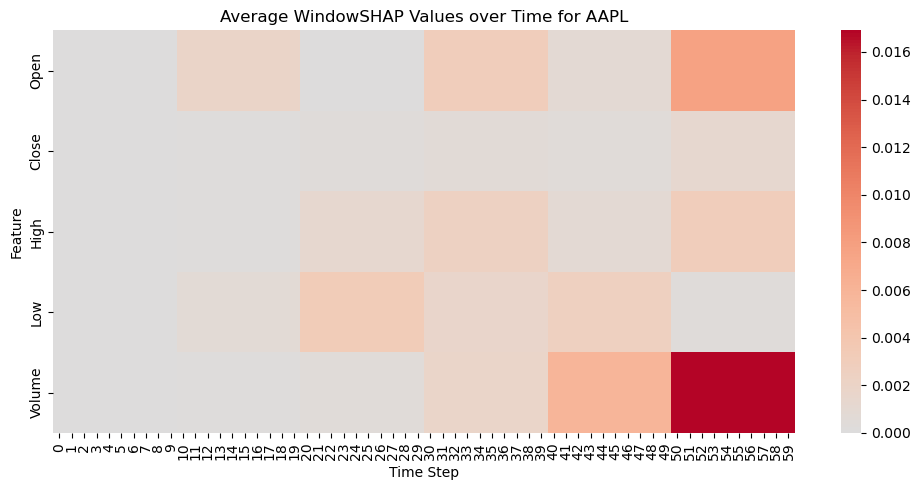

WindowSHAP heatmap of average values over time


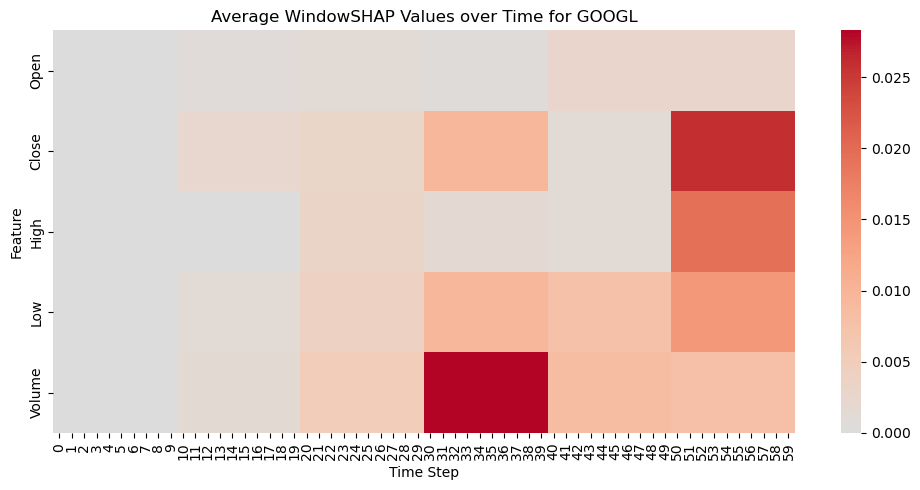

WindowSHAP heatmap of average values over time


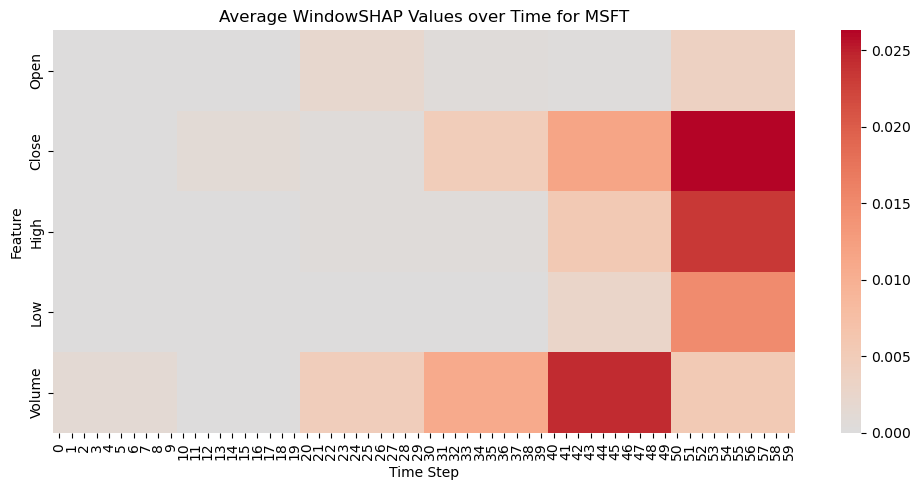

WindowSHAP heatmap of average values over time


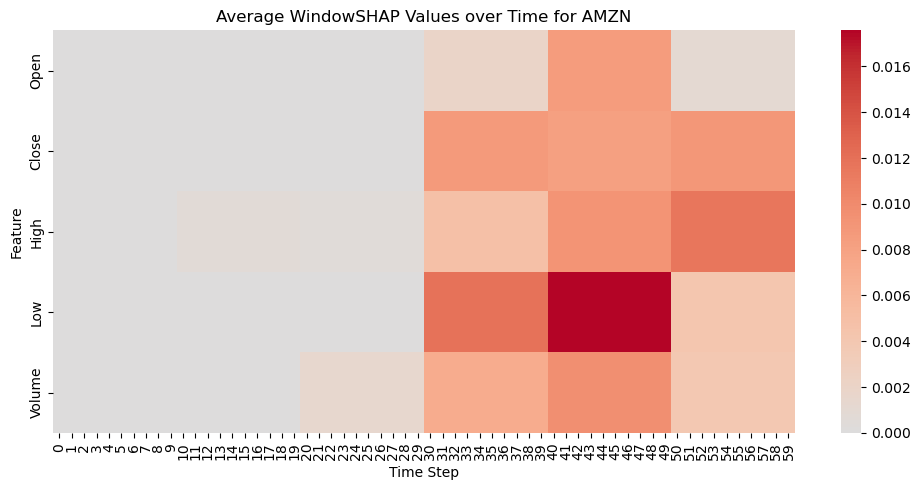

In [101]:
## Step 6 : Visualize WindowSHAP values
shap.initjs()

for ticker in tickers_list:

    # Load data
    X_test = X_test_sets[ticker]
    # window_shap_values = window_shap_values_map[ticker]
    avg_window_shap = avg_window_shap_values_map[ticker]  # shape: (timesteps, features)
    feature_names = included_features

    '''
    # === AVERAGE SHAP WATERFALL + FORCE PLOT ===
    timestep = -1  # e.g., last timestep of the average

    avg_window_shap_1d = avg_window_shap[timestep]  # shape: (features,)
    avg_window_shap_1d = avg_window_shap_1d.reshape(-1)
    dummy_features = np.zeros_like(avg_window_shap_1d)

    avg_window_shap_explanation = shap.Explanation(
        values=avg_window_shap_1d,
        base_values=0,
        data=dummy_features,
        feature_names=feature_names
    )

    print(f"\nVisualizing **AVERAGE** WindowSHAP for {ticker} (Timestep {timestep})...")
    shap.plots.waterfall(avg_window_shap_explanation, max_display=len(feature_names))
    shap.plots.force(avg_window_shap_explanation, matplotlib=True)

    # === SHAP Summary Plot for All Samples ===
    print("WindowSHAP summary plot for all test samples")
    num_samples = window_shap_values.shape[0]

    shap.summary_plot(
        window_shap_values.reshape(-1, window_shap_values.shape[-1]),  # shape: (samples * timesteps, features)
        X_test[:num_samples].reshape(-1, X_test.shape[-1]),            # shape: (samples * timesteps, features)
        feature_names=feature_names
    )
    '''

    # === Heatmap of Average WindowSHAP over Time ===
    print("WindowSHAP heatmap of average values over time")

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        avg_window_shap.T,  # shape: (features, timesteps)
        xticklabels=True,
        yticklabels=feature_names,
        cmap='coolwarm',
        center=0
    )
    plt.title(f'Average WindowSHAP Values over Time for {ticker}')
    plt.xlabel('Time Step')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [105]:
# Step 7 : Compute feature-based WindowSHAP

from statsmodels.tsa.seasonal import seasonal_decompose

trend_window_shap_values_map = {}
season_window_shap_values_map = {}
resid_window_shap_values_map = {}

avg_trend_window_shap_values_map = {}
avg_season_window_shap_values_map = {}
avg_resid_window_shap_values_map = {}

# --- 1. Decompose each feature in each sample ---

def decompose_series(ts, period=12):
    result = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid
    return trend, seasonal, resid

def decompose_dataset(X, period=12):
    n_samples, n_timesteps, n_features = X.shape
    trend_data = np.zeros_like(X)
    seasonal_data = np.zeros_like(X)
    resid_data = np.zeros_like(X)

    for i in range(n_samples):
        for j in range(n_features):
            ts = pd.Series(X[i, :, j])
            trend, seasonal, resid = decompose_series(ts, period)
            trend_data[i, :, j] = trend
            seasonal_data[i, :, j] = seasonal
            resid_data[i, :, j] = resid
    
    return trend_data, seasonal_data, resid_data

for ticker in tickers_list:
    print(f"\nProcessing ticker {ticker}...")

    model = models[ticker]
    X_train = X_train_sets[ticker]
    X_test = X_test_sets[ticker]

    # Decompose train and test data
    trend_train, seasonal_train, resid_train = decompose_dataset(X_train)
    trend_test, seasonal_test, resid_test = decompose_dataset(X_test)

    background_size = min(10, len(trend_train))  # you can adjust this based on performance

    # Downsample if needed, like in your WindowSHAP example
    # Example: every 3rd timestep (adjust as you see fit)
    trend_train_ds = trend_train[:background_size, ::3, :]
    trend_test_ds = trend_test[:10, ::3, :]

    seasonal_train_ds = seasonal_train[:background_size, ::3, :]
    seasonal_test_ds = seasonal_test[:10, ::3, :]

    resid_train_ds = resid_train[:background_size, ::3, :]
    resid_test_ds = resid_test[:10, ::3, :]

    # Window size per your choice, could also vary per component
    window_size = 10

    # Compute WindowSHAP for trend
    print(f"Computing WindowSHAP for trend component of {ticker}...")
    trend_window_shap_values = np.zeros((len(trend_test_ds), trend_test_ds.shape[1], trend_test_ds.shape[2]))
    for i in tqdm(range(len(trend_test_ds)), desc=f'WindowSHAP - Trend - {ticker}'):
        shap_vals = compute_window_shap(model, trend_train_ds, trend_test_ds[i:i+1], window_size=window_size)
        trend_window_shap_values[i, :, :] = shap_vals

    # Compute WindowSHAP for seasonal
    print(f"Computing WindowSHAP for seasonal component of {ticker}...")
    seasonal_window_shap_values = np.zeros((len(seasonal_test_ds), seasonal_test_ds.shape[1], seasonal_test_ds.shape[2]))
    for i in tqdm(range(len(seasonal_test_ds)), desc=f'WindowSHAP - Seasonal - {ticker}'):
        shap_vals = compute_window_shap(model, seasonal_train_ds, seasonal_test_ds[i:i+1], window_size=window_size)
        seasonal_window_shap_values[i, :, :] = shap_vals

    # Compute WindowSHAP for residual
    print(f"Computing WindowSHAP for residual component of {ticker}...")
    resid_window_shap_values = np.zeros((len(resid_test_ds), resid_test_ds.shape[1], resid_test_ds.shape[2]))
    for i in tqdm(range(len(resid_test_ds)), desc=f'WindowSHAP - Residual - {ticker}'):
        shap_vals = compute_window_shap(model, resid_train_ds, resid_test_ds[i:i+1], window_size=window_size)
        resid_window_shap_values[i, :, :] = shap_vals

    # Store results in your dictionary
    trend_window_shap_values_map[ticker] = trend_window_shap_values
    season_window_shap_values_map[ticker] = seasonal_window_shap_values
    resid_window_shap_values_map[ticker] = resid_window_shap_values
    
    avg_trend_window_shap_values_map[ticker] = np.mean(trend_window_shap_values, axis=0)  # shape: (timesteps, features)
    avg_season_window_shap_values_map[ticker] = np.mean(seasonal_window_shap_values, axis=0)
    avg_resid_window_shap_values_map[ticker] = np.mean(resid_window_shap_values, axis=0)

    print(f"WindowSHAP computation done for {ticker}.")


Processing ticker AAPL...
Computing WindowSHAP for trend component of AAPL...


WindowSHAP - Trend - AAPL: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Computing WindowSHAP for seasonal component of AAPL...


WindowSHAP - Seasonal - AAPL: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


Computing WindowSHAP for residual component of AAPL...


WindowSHAP - Residual - AAPL: 100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


WindowSHAP computation done for AAPL.

Processing ticker GOOGL...
Computing WindowSHAP for trend component of GOOGL...


WindowSHAP - Trend - GOOGL: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Computing WindowSHAP for seasonal component of GOOGL...


WindowSHAP - Seasonal - GOOGL: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Computing WindowSHAP for residual component of GOOGL...


WindowSHAP - Residual - GOOGL: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


WindowSHAP computation done for GOOGL.

Processing ticker MSFT...
Computing WindowSHAP for trend component of MSFT...


WindowSHAP - Trend - MSFT: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Computing WindowSHAP for seasonal component of MSFT...


WindowSHAP - Seasonal - MSFT: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Computing WindowSHAP for residual component of MSFT...


WindowSHAP - Residual - MSFT: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


WindowSHAP computation done for MSFT.

Processing ticker AMZN...
Computing WindowSHAP for trend component of AMZN...


WindowSHAP - Trend - AMZN: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Computing WindowSHAP for seasonal component of AMZN...


WindowSHAP - Seasonal - AMZN: 100%|██████████| 10/10 [00:20<00:00,  2.10s/it]


Computing WindowSHAP for residual component of AMZN...


WindowSHAP - Residual - AMZN: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

WindowSHAP computation done for AMZN.



Ticker: AAPL
SHAP heatmaps over time for sample 0, ticker AAPL


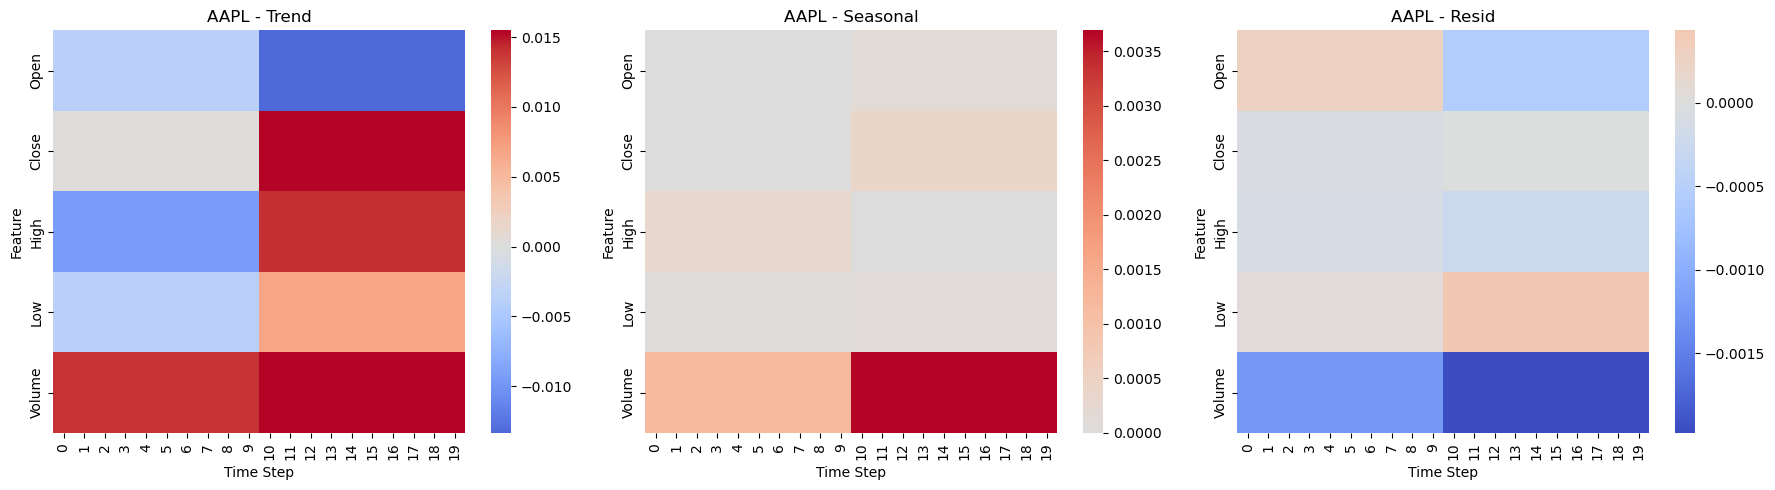


Ticker: GOOGL
SHAP heatmaps over time for sample 0, ticker GOOGL


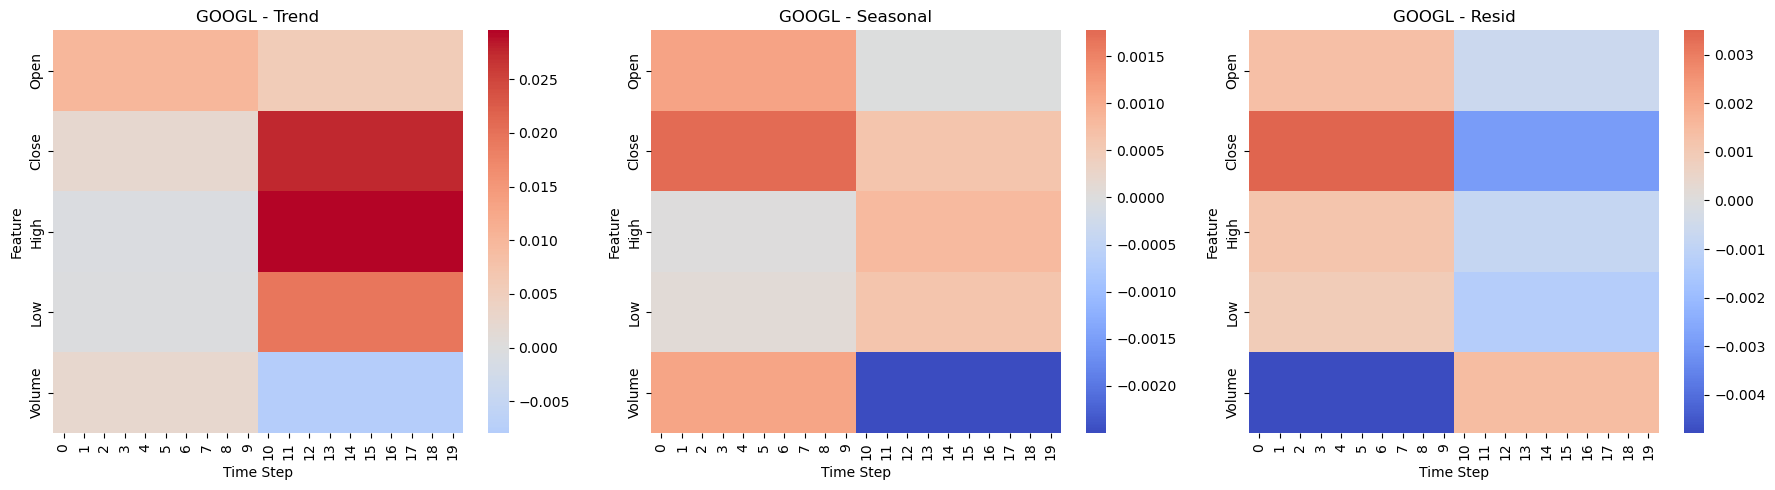


Ticker: MSFT
SHAP heatmaps over time for sample 0, ticker MSFT


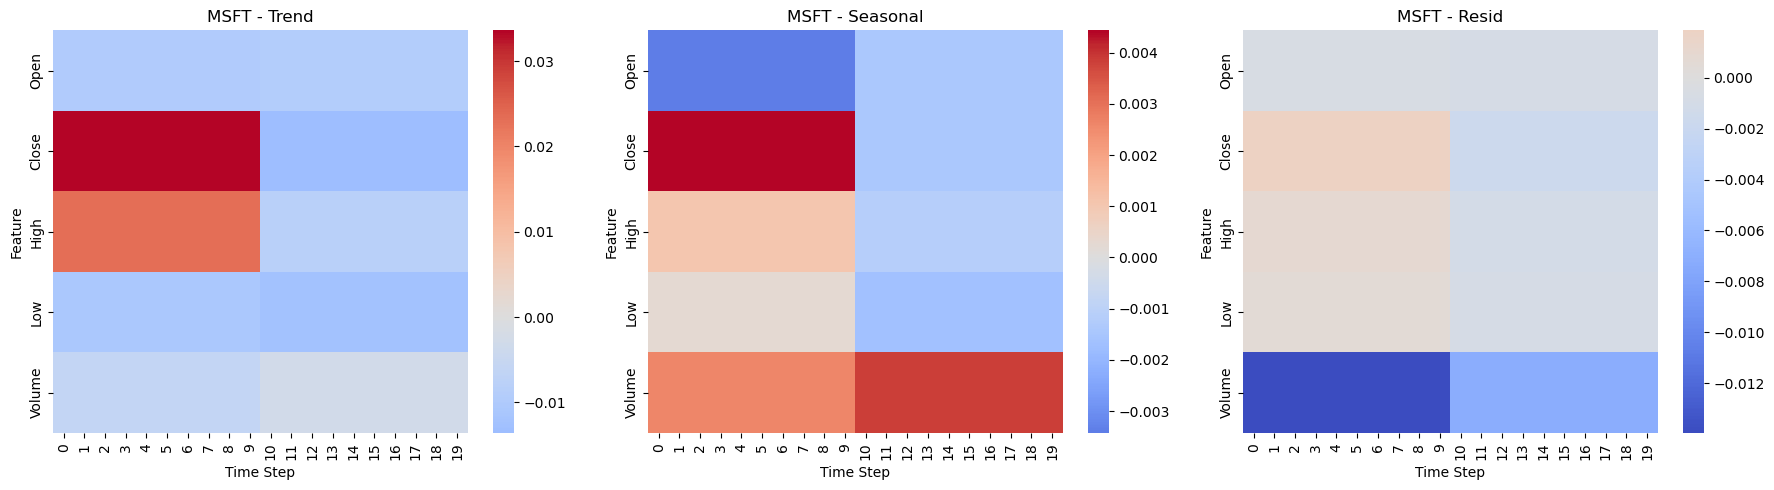


Ticker: AMZN
SHAP heatmaps over time for sample 0, ticker AMZN


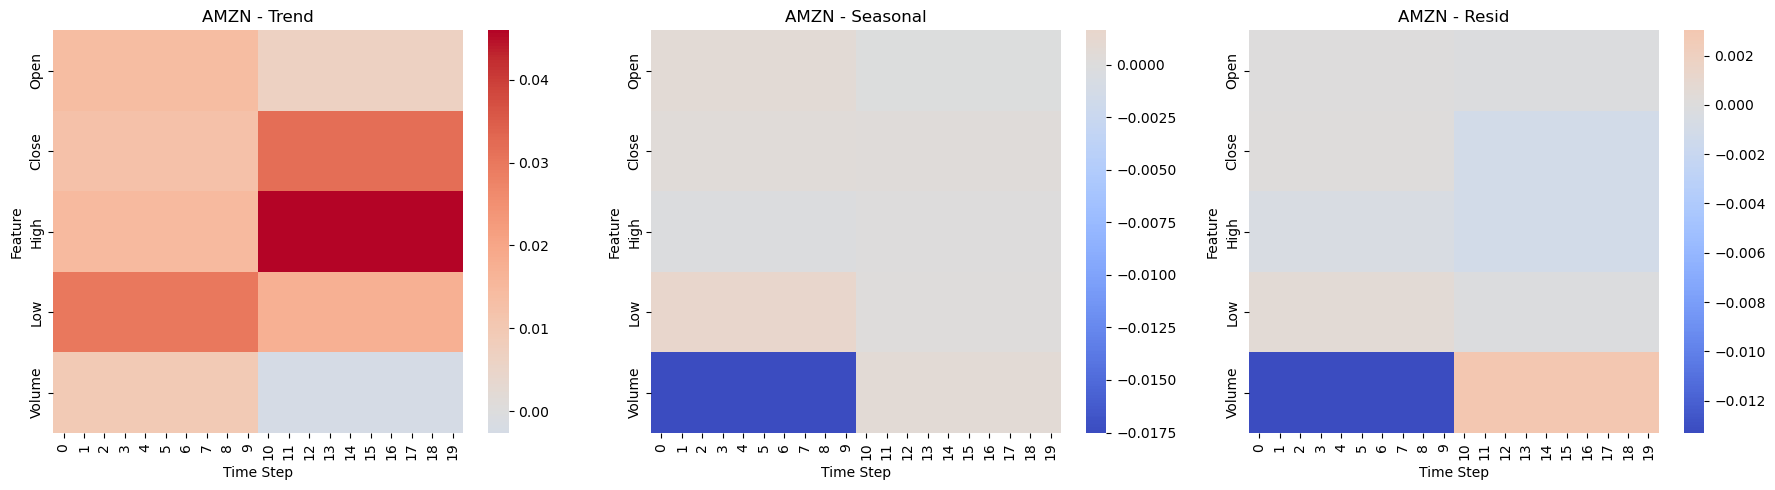

In [107]:
shap.initjs()
components = ['trend', 'seasonal', 'resid']
sample_idx = 0  # Which test sample to visualize
timestep_labels = True  # Turn off if too many time steps

for ticker in tickers_list:
    print(f"\nTicker: {ticker}")
    feature_names = included_features
    X_test = X_test_sets[ticker]  # Optional: X_test = X_test[:, ::3, :]

    # Load SHAP values
    trend_shap = trend_window_shap_values_map[ticker]
    seasonal_shap = season_window_shap_values_map[ticker]
    resid_shap = resid_window_shap_values_map[ticker]

    shap_values_dict = {
        'trend': trend_shap,
        'seasonal': seasonal_shap,
        'resid': resid_shap
    }

    # --- Plot heatmaps for single sample ---
    print(f"SHAP heatmaps over time for sample {sample_idx}, ticker {ticker}")
    fig, axes = plt.subplots(1, len(components), figsize=(18, 5))

    for i, comp in enumerate(components):
        comp_shap = shap_values_dict[comp]
        sns.heatmap(
            comp_shap[sample_idx].T,  # shape: (features, timesteps)
            xticklabels=timestep_labels,
            yticklabels=feature_names,
            cmap='coolwarm',
            center=0,
            ax=axes[i]
        )
        axes[i].set_title(f"{ticker} - {comp.capitalize()}")
        axes[i].set_xlabel("Time Step")
        axes[i].set_ylabel("Feature")

    plt.tight_layout()
    plt.show()

In [ ]:
## Step 8 : Visualize decomposed WindowSHAP values
shap.initjs()

components = ['trend', 'seasonal', 'resid']


for ticker in tickers_list:
    print(f"\nTicker: {ticker}")

    # X_test = X_test_sets[ticker][:, ::3, :]
    feature_names = included_features
    sample_idx = 0
    timestep = -1

    # Load WindowSHAP values for each component using your keys
    trend_window_shap_values = trend_window_shap_values_map[ticker]
    seasonal_window_shap_values = season_window_shap_values_map[ticker]
    resid_window_shap_values = resid_window_shap_values_map[ticker]

    avg_trend_window_shap_values = avg_trend_window_shap_values_map[ticker]
    avg_season_window_shap_values = avg_season_window_shap_values_map[ticker]
    avg_resid_window_shap_values = avg_resid_window_shap_values_map[ticker]

    shap_values_dict = {
        'trend': trend_window_shap_values,
        'seasonal': seasonal_window_shap_values,
        'resid': resid_window_shap_values
    }

    avg_shap_values_dict = {
        'trend': avg_trend_window_shap_values,
        'seasonal': avg_season_window_shap_values,
        'resid': avg_resid_window_shap_values
    }
    

    for comp in components:
        print(f"\nComponent: {comp}")
        comp_shap_values = shap_values_dict[comp]
        comp_avg_shap_values = avg_shap_values_dict[comp]

        window_shap_values_1d = comp_shap_values[sample_idx, timestep, :]
        features_1d = X_test[sample_idx, timestep, :]

        # -- Single Sample --
        window_shap_explanation = shap.Explanation(
            values=window_shap_values_1d,
            base_values=0,
            data=features_1d,
            feature_names=feature_names
        )

        print(f"Waterfall plot for {ticker} - {comp}")
        shap.plots.waterfall(window_shap_explanation, max_display=len(feature_names))

        print(f"Force plot for {ticker} - {comp}")
        shap.plots.force(window_shap_explanation, matplotlib=True)

        # -- Average SHAP --
        avg_values_1d = comp_avg_shap_values[timestep, :]
        dummy_features = np.zeros_like(avg_values_1d)

        avg_explanation = shap.Explanation(
            values=avg_values_1d,
            base_values=0,
            data=dummy_features,
            feature_names=feature_names
        )

        print(f"Average Waterfall plot for {ticker} - {comp}")
        shap.plots.waterfall(avg_explanation, max_display=len(feature_names))

        print(f"Average Force plot for {ticker} - {comp}")
        shap.plots.force(avg_explanation, matplotlib=True)

        


In [84]:
from numpy import percentile


def eval_perturbation(model, X_test, y_pred, y_test, percentiles, shap_values, is_windowshap=True, mask_value=0):
    num_samples, num_timesteps, num_features = X_test.shape
    losses = []

    og_loss = np.mean((y_pred - y_test)**2)

    for p in percentiles:
        perturbed_X = X_test.copy()

        for i in range(num_samples):
            if is_windowshap:
                # SHAP shape: (timesteps, features)
                shap_importance = np.abs(shap_values[i]).sum(axis=1)
                top_timesteps = np.argsort(shap_importance)[-int(num_timesteps * p / 100):]
                perturbed_X[i, top_timesteps, :] = mask_value

            else:
                # SHAP shape: (features,)
                shap_importance = np.abs(shap_values[i])
                top_features = np.argsort(shap_importance)[-int(num_features * p / 100):]
                perturbed_X[i, :, top_features] = mask_value  # <-- this must modify X_test

        # Ensure prediction changes after masking
        perturbed_pred = model.predict(perturbed_X, verbose=0)
        perturbed_loss = np.mean((perturbed_pred - y_test)**2)
        percent_change = (perturbed_loss - og_loss) / og_loss * 100
        losses.append(percent_change)

    return np.array(losses)


percentiles = np.arange(60, 91)
methods = ['SHAP', 'WindowSHAP', 'Decomposed WindowSHAP']
shap_results = {}
window_shap_results = {}
decomp_shap_results = {}

for ticker in tickers_list:
    print(f"\nEvaluating perturbation for {ticker}...")
    model = models[ticker]
    X_test = X_test_sets[ticker]
    y_pred = y_pred_sets[ticker]
    y_test = y_test_sets[ticker]

    # SHAP
    shap_values = shap_values_map[ticker]
    shap_scores = eval_perturbation(
        model,
        X_test,
        y_pred,
        y_test,
        percentiles,
        shap_values=np.squeeze(shap_values_map[ticker], axis=-1),  # shape: (samples, timesteps, features)
        is_windowshap=True  # this is important
    )

    shap_results[ticker] = shap_scores

    # WindowSHAP
    window_shap_values = window_shap_values_map[ticker]
    window_shap_scores = eval_perturbation(model, X_test, y_pred, y_test, percentiles, shap_values=window_shap_values_map[ticker], is_windowshap=True)
    window_shap_results[ticker] = window_shap_scores

    
    


Evaluating perturbation for AAPL...

Evaluating perturbation for GOOGL...

Evaluating perturbation for MSFT...

Evaluating perturbation for AMZN...


Plotting perturbation analysis for AAPL...


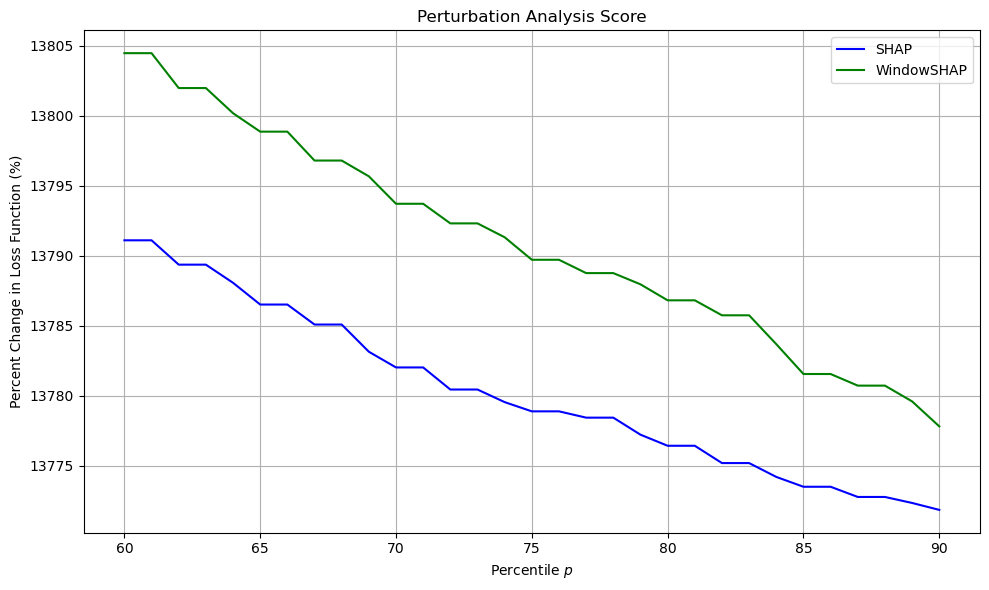

Plotting perturbation analysis for GOOGL...


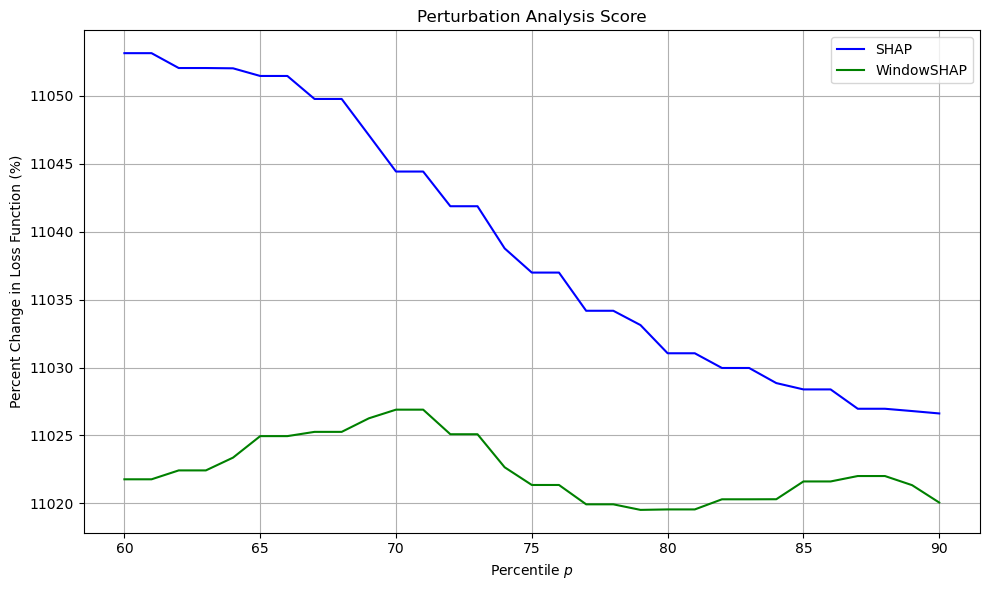

Plotting perturbation analysis for MSFT...


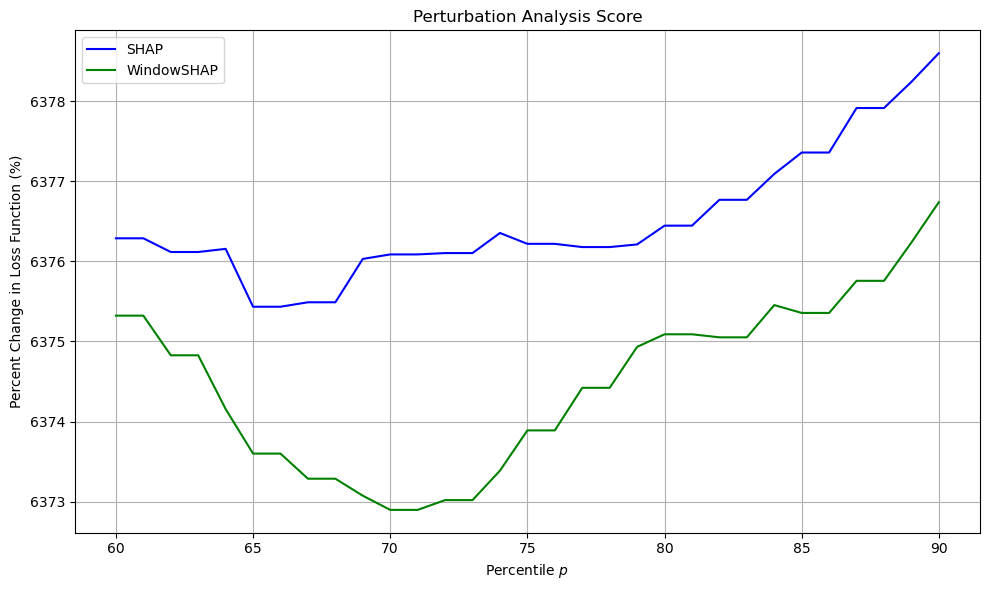

Plotting perturbation analysis for AMZN...


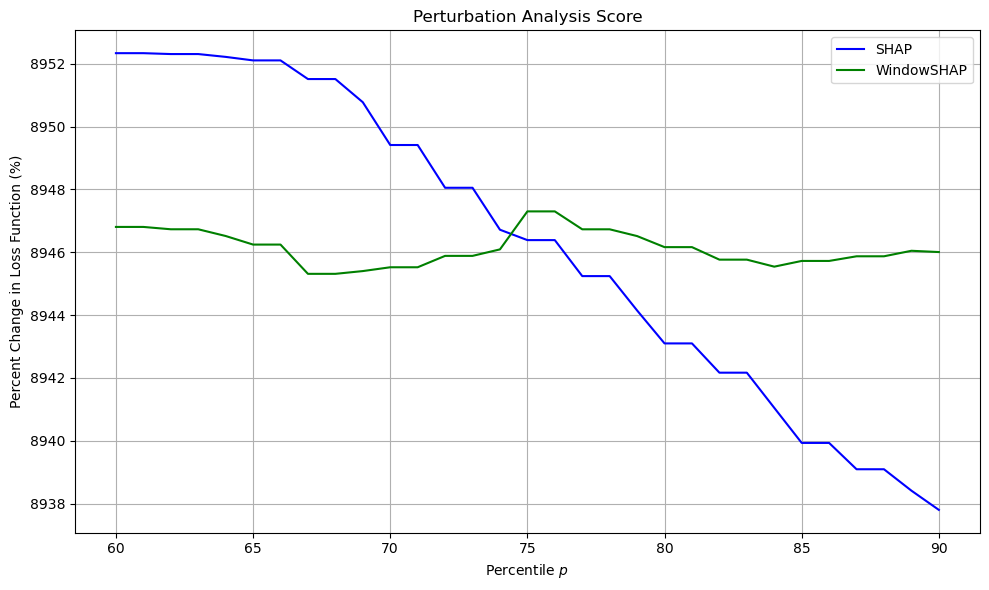

SHAP shape: (55, 60, 5, 1)


In [ ]:
def plot_perturbation_analysis(percentiles, shap_results, window_shap_results, ticker=None):
    plt.figure(figsize=(10, 6))

    def get_mean_std(results_dict):
        all_scores = np.array(list(results_dict.values()))
        return np.mean(all_scores, axis=0), np.std(all_scores, axis=0)

    if ticker:
        # Plot for one specific ticker
        plt.plot(percentiles, shap_results[ticker], label='SHAP', color='blue')
        plt.plot(percentiles, window_shap_results[ticker], label='WindowSHAP', color='green')
    else:
        # Mean + std over all tickers
        shap_mean, shap_std = get_mean_std(shap_results)
        win_mean, win_std = get_mean_std(window_shap_results)

        plt.plot(percentiles, shap_mean, label='SHAP', color='blue')
        plt.fill_between(percentiles, shap_mean - shap_std, shap_mean + shap_std, color='blue', alpha=0.2)

        plt.plot(percentiles, win_mean, label='WindowSHAP', color='green')
        plt.fill_between(percentiles, win_mean - win_std, win_mean + win_std, color='green', alpha=0.2)

    plt.title("Perturbation Analysis Score")
    plt.xlabel("Percentile $p$")
    plt.ylabel("Percent Change in Loss Function (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for ticker in tickers_list:
    print(f"Plotting perturbation analysis for {ticker}...")
    plot_perturbation_analysis(
        percentiles,
        shap_results,
        window_shap_results,
        ticker=ticker
    )